In [ ]:
!apt update
!apt install chromium-chromedriver
!pip install selenium
!pip install tensorflow
!pip install -q keras
!pip install pick
!cp /usr/lib/chromium-browser/chromedriver /content/drive/MyDrive/Colab_Notebooks/CrossyRoad

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:11 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Sources [1,757 kB]
Get:12 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main amd64 Packages [899 kB]
Get:13 https://cloud.r-project.org/bin/linux/ubuntu 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from collections import deque

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC

import cv2 as cv

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam

import numpy as np
import pandas as pd
import random
import pickle
import time
import os
import base64
from io import BytesIO
from PIL import Image
from IPython.display import display, clear_output
import json

In [ ]:
GAME_URL = 'file:///content/drive/MyDrive/Colab_Notebooks/CrossyRoad/web/index.html'

OBJ_PATH = '/content/drive/MyDrive/Colab_Notebooks/CrossyRoad/object/'

MODEL_FILE_PATH = OBJ_PATH + 'model.h5'

LOSS_FILE_PATH = OBJ_PATH + 'loss_df.csv'
ACTIONS_FILE_PATH = OBJ_PATH +'actions_df.csv'
Q_VALUES_FILE_PATH = OBJ_PATH + 'q_values.csv'
SCORES_FILE_PATH = OBJ_PATH + 'scores_df.csv'

# Set the browser size
WINDOW_SIZE_W = 1200
WINDOW_SIZE_H = 600

#Intialize log structures from file if exists else create new
loss_df = pd.read_csv(LOSS_FILE_PATH) if os.path.isfile(LOSS_FILE_PATH) else pd.DataFrame(columns =['loss'])
scores_df = pd.read_csv(SCORES_FILE_PATH) if os.path.isfile(SCORES_FILE_PATH) else pd.DataFrame(columns = ['scores'])
actions_df = pd.read_csv(ACTIONS_FILE_PATH) if os.path.isfile(ACTIONS_FILE_PATH) else pd.DataFrame(columns = ['actions'])
q_values_df =pd.read_csv(Q_VALUES_FILE_PATH) if os.path.isfile(Q_VALUES_FILE_PATH) else pd.DataFrame(columns = ['qvalues'])

In [ ]:
reward_func = {'score_dep': True,
                 'delta_score': True,
                 'move_list': [0.1, 0.1, 0.1, 0.1],
                 'reward_weights': [1, 1, 1, 1],
                 'dead_punishment': -10,
                 'resize_w': 80,
                 'resize_h': 80,
                 'canny_th1': 100,
                 'canny_th2': 200,
                 'learning_rate': 1e-4,
                 'initial_epsilon': 0.2,
                 'final_epsilon': 0.001,
                 'observe': 1000,
                 'explore': 1000,
                 'replay_memory': 5000,
                 'batch': 32,
                 'gamma': 0.99}

In [ ]:
def build_model():
    model = Sequential()

    model.add(Conv2D(32, (8, 8), padding='same', strides=(4, 4), input_shape=(80, 80, 4)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))

    model.add(Dense(4))

    adam = Adam(lr=reward_func['learning_rate'])
    model.compile(loss='mse', optimizer=adam)

    if not os.path.isfile(MODEL_FILE_PATH):
        model.save_weights(MODEL_FILE_PATH)
    return model

In [ ]:
def save_obj(obj, name):
  with open(OBJ_PATH + name + '.pkl', 'wb') as f:
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
  with open(OBJ_PATH + name + '.pkl', 'rb') as f:
    return pickle.load(f)

In [ ]:
def init_cache():
    if not os.path.isfile(OBJ_PATH + 'time.pkl'):
        print('Initialize the cache')
        save_obj(reward_func['initial_epsilon'], 'epsilon')
        t = 0
        save_obj(t, 'time')
        memo = deque()
        save_obj(memo, 'memory')

init_cache()

In [ ]:
class Game:
    def __init__(self, on_cloud=True):
        chrome_options = Options()
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--disable-dev-shm-usage')
        self.driver = webdriver.Chrome(chrome_options=chrome_options)
        self.driver.set_window_size(WINDOW_SIZE_W, WINDOW_SIZE_H)
        self.driver.get(GAME_URL)
        self._paused = False
        self.element = self.driver.find_element_by_id('retry')

    def forward(self):
        self.driver.find_element_by_id("forward").send_keys(Keys.UP)

    def backward(self):
        self.driver.find_element_by_id("backward").send_keys(Keys.DOWN)

    def left(self):
        self.driver.find_element_by_id('left').send_keys(Keys.LEFT)

    def right(self):
        self.driver.find_element_by_id('right').send_keys(Keys.RIGHT)

    def get_score(self):
        text_score = self.driver.find_element_by_id('counter').text
        return int(text_score)

    def get_crashed(self):
        retry_element = self.driver.find_element_by_id('retry')
        return retry_element.is_displayed()

    def restart_game(self):
        WebDriverWait(self.driver, 1).until(EC.element_to_be_clickable((By.ID, "retry"))).click()

    def end(self):
        self.driver.close()

    def pause_or_resume(self):
        action = ActionChains(self.driver)
        action.send_keys(Keys.ENTER).perform()
        self._paused = not self._paused

    def pause(self):
        if not self._paused:
            self.pause_or_resume()

    def resume(self):
        if self._paused:
            self.pause_or_resume()

    def get_paused(self):
        return self._paused

    def end_game(self):
        self.driver.close()

In [ ]:
class Game_State:
    def __init__(self, game):
        self.game = game

    def processing_img(self):
        img_64 = self.game.driver.find_element_by_id('imgURL').text
        display(Image.open(BytesIO(base64.b64decode(img_64))))
        screen = np.array(Image.open(BytesIO(base64.b64decode(img_64))))
        img = cv.cvtColor(screen, cv.COLOR_RGBA2GRAY)
        img = img[200:400, 650:850]
        img = cv.resize(img, (reward_func['resize_w'], reward_func['resize_h']))
        img = cv.Canny(img,
                       threshold1=reward_func['canny_th1'],
                       threshold2=reward_func['canny_th2'])

        return img

    def get_reward(self, action, is_dead, old_score):
        if action == -1:
            return 0

        if is_dead:
            return reward_func['dead_punishment']

        if not reward_func['score_dep']:
            return reward_func['move_list'][action]

        score = self.game.get_score()

        if reward_func['delta_score']:
            score -= old_score

        return score * reward_func['reward_weights'][action]

    def get_state(self, action):
        old_score = self.game.get_score()

        if action == 0:
            self.game.forward()
        elif action == 1:
            self.game.left()
        elif action == 2:
            self.game.right()
        elif action == 3:
            self.game.backward()

        image = self.processing_img()
        is_dead = self.game.get_crashed()
        new_score = self.game.get_score()
        reward = self.get_reward(action, is_dead, old_score)

        if is_dead:
            self.game.restart_game()

        return image, reward, is_dead, new_score

In [ ]:
def train_nn(model, game_state):
    memo = load_obj('memory')
    do_nothing = -1
    t = load_obj('time')
    epsilon = load_obj('epsilon')

    if os.path.isfile(MODEL_FILE_PATH):
        model.load_weights(MODEL_FILE_PATH)
        adam = Adam(learning_rate=reward_func['learning_rate'])
        model.compile(loss='mse', optimizer=adam)

    image_t, reward_0, is_dead, game_score = game_state.get_state(do_nothing)
    state_t = np.stack((image_t, image_t, image_t, image_t), axis=2)
    state_t = state_t.reshape(1, state_t.shape[0], state_t.shape[1], state_t.shape[2])

    while True:
        loss = 0
        Q_sa = 0
        reward = 0
        action_t = do_nothing

        game_state.game.pause()
        if t < reward_func['observe']:
            action_t = random.randrange(4)
        else:
            pred = model.predict(state_t)
            max_Q = np.argmax(pred)
            action_t = max_Q
        game_state.game.resume()

        if epsilon > reward_func['final_epsilon'] and t > reward_func['observe']:
            epsilon -= (reward_func['initial_epsilon'] - reward_func['final_epsilon']) / reward_func['explore']

        image_t1, reward_t, is_dead, game_score = game_state.get_state(action_t)
        image_t1 = image_t1.reshape(1, image_t1.shape[0], image_t1.shape[1], 1)
        state_t1 = np.append(image_t1, state_t[:,:,:,:3], axis=3)

        memo.append((state_t, action_t, reward_t, state_t1, is_dead))

        if len(memo) > reward_func['replay_memory']:
            memo.popleft()

        game_state.game.pause()

        if t > reward_func['observe']:
            minibatch = random.sample(memo, reward_func['batch'])
            inputs = np.zeros((reward_func['batch'], state_t.shape[1], state_t.shape[2], state_t.shape[3]))
            targets = np.zeros((inputs.shape[0], 4))

            for i in range(len(minibatch)):
                state_t = minibatch[i][0]
                action_t = minibatch[i][1]
                reward_t = minibatch[i][2]
                state_t1 = minibatch[i][3]
                is_dead = minibatch[i][4]

                inputs[i:i+1] = state_t
                targets[i] = model.predict(state_t)
                Q_sa = model.predict(state_t1)

                if is_dead:
                    targets[i, action_t] = reward_t
                else:
                    targets[i, action_t] = reward_t + reward_func['gamma'] * np.max(Q_sa)

            loss += model.train_on_batch(inputs, targets)
            loss_df.loc[len(loss_df)] = loss
            q_values_df.loc[len(q_values_df)] = np.max(Q_sa)

        state_t = state_t1
        t += 1

        if t%50 == 0:
            print('Now we save model')
            model.save_weights(MODEL_FILE_PATH, overwrite=True)
            save_obj(memo, 'memory')
            save_obj(t, 'time')
            save_obj(epsilon, 'epsilon')
            loss_df.to_csv(LOSS_FILE_PATH, index=False)
            scores_df.to_csv(SCORES_FILE_PATH, index=False)
            actions_df.to_csv(ACTIONS_FILE_PATH, index=False)
            q_values_df.to_csv(Q_VALUES_FILE_PATH, index=False)
            print('Finished Saving')
            clear_output()

        state = ""
        if t <= reward_func['observe']:
            state = "observe"
        elif reward_func['observe'] < t <= reward_func['observe'] + reward_func['explore']:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t,
              "/ STATE", state,
              "/ EPSILON", epsilon,
              "/ ACTION", action_t,
              "/ REWARD", reward_t,
              "/ SCORE", game_score,
              "/ Q_MAX " , np.max(Q_sa),
              "/ Loss ", loss,
              "/ Is Dead", is_dead)
        
        game_state.game.resume()

In [ ]:
game = Game()
model = build_model()
game_state = Game_State(game)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: use options instead of chrome_options
  import sys


TIMESTEP 2450 / STATE train / EPSILON 0.0009999999999970072 / ACTION 1 / REWARD 0 / SCORE 0 / Q_MAX  20.043636 / Loss  15.617315292358398 / Is Dead False


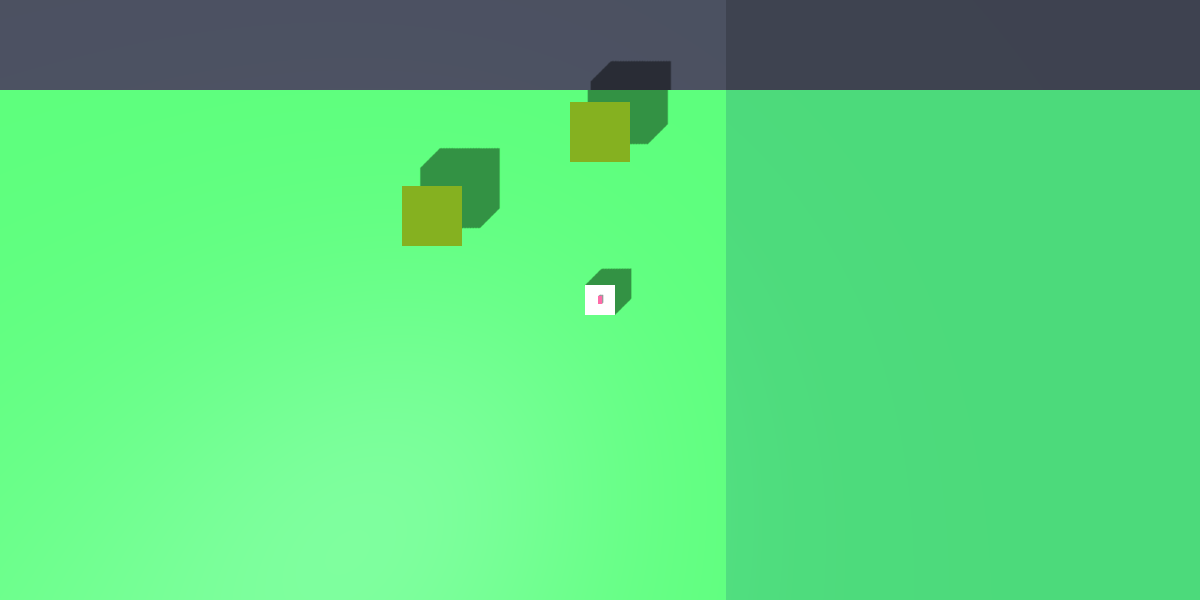

TIMESTEP 2451 / STATE train / EPSILON 0.0009999999999970072 / ACTION 3 / REWARD 0 / SCORE 0 / Q_MAX  28.192907 / Loss  5.549862861633301 / Is Dead False


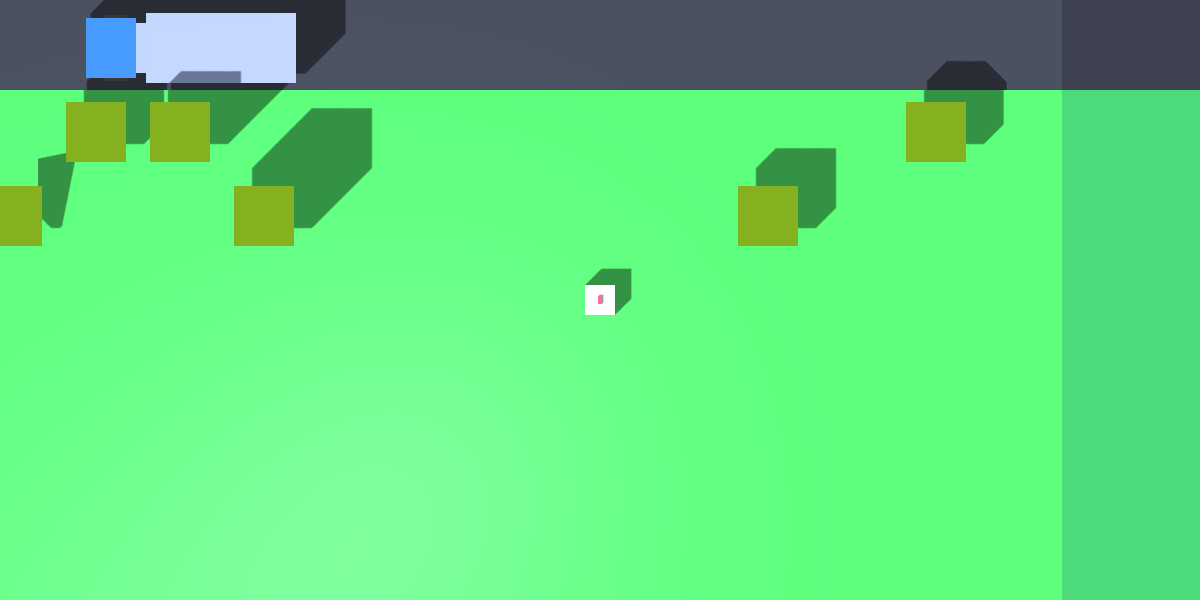

TIMESTEP 2452 / STATE train / EPSILON 0.0009999999999970072 / ACTION 0 / REWARD 0 / SCORE 0 / Q_MAX  25.215855 / Loss  8.647232055664062 / Is Dead False


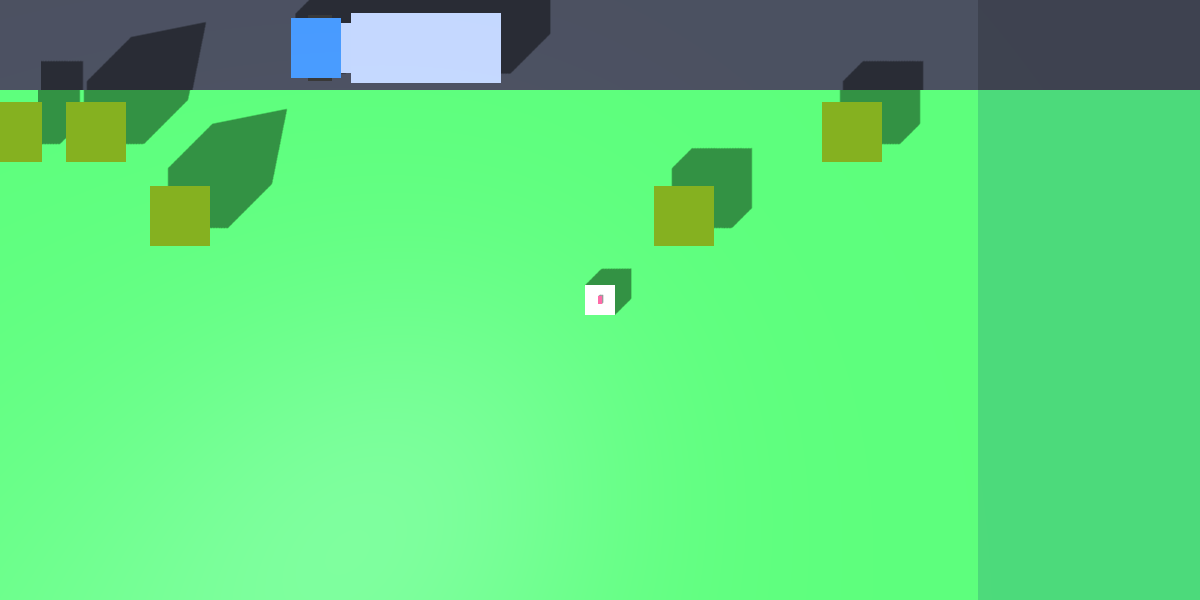

TIMESTEP 2453 / STATE train / EPSILON 0.0009999999999970072 / ACTION 2 / REWARD 0 / SCORE 0 / Q_MAX  8.195707 / Loss  16.18486213684082 / Is Dead False


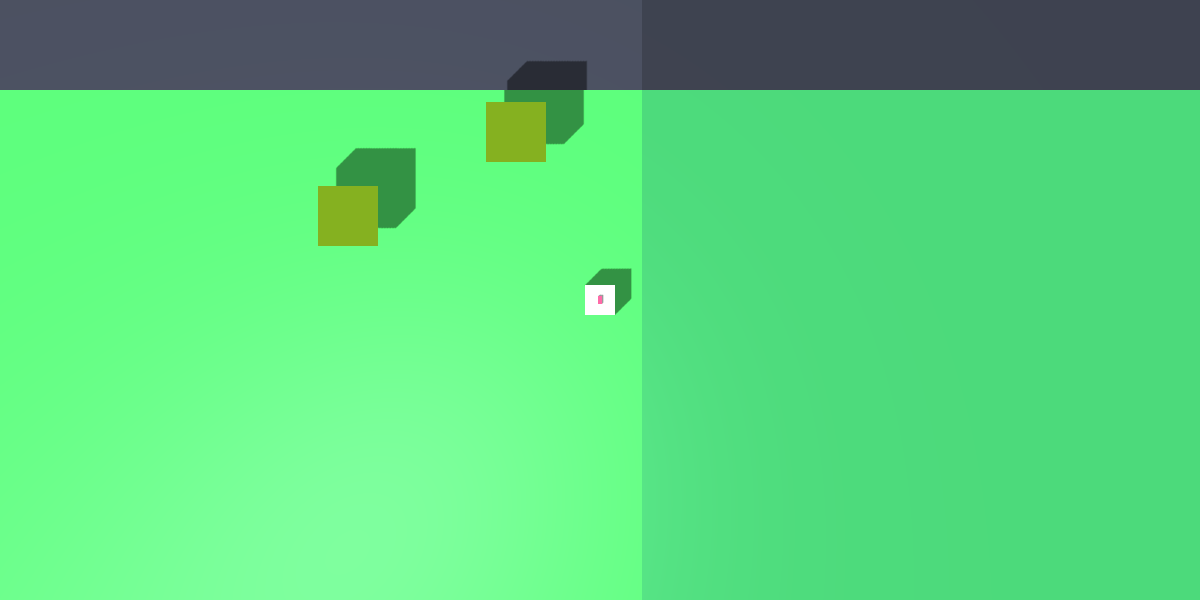

TIMESTEP 2454 / STATE train / EPSILON 0.0009999999999970072 / ACTION 2 / REWARD 0 / SCORE 0 / Q_MAX  23.256407 / Loss  4.413420677185059 / Is Dead False


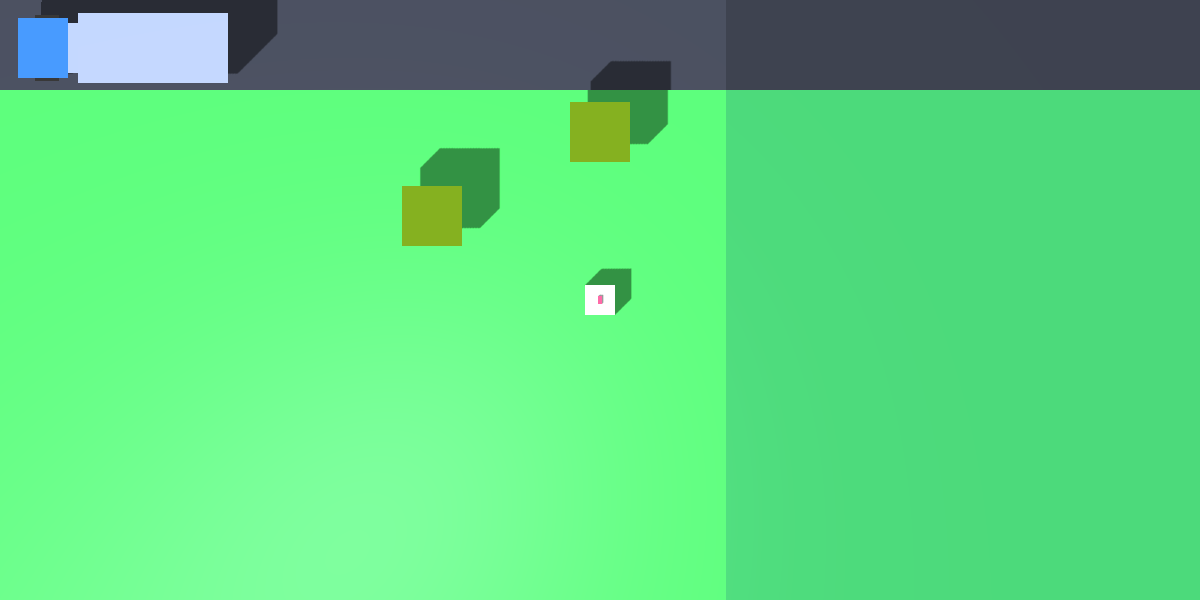

TIMESTEP 2455 / STATE train / EPSILON 0.0009999999999970072 / ACTION 1 / REWARD 0 / SCORE 0 / Q_MAX  22.298443 / Loss  7.075584888458252 / Is Dead False


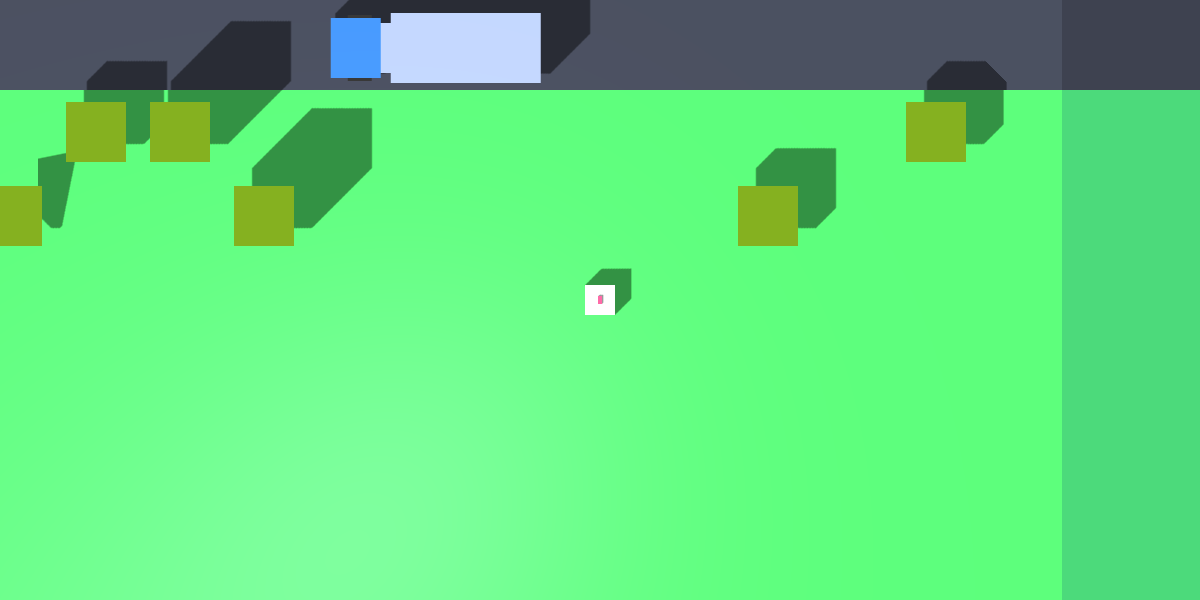

TIMESTEP 2456 / STATE train / EPSILON 0.0009999999999970072 / ACTION 3 / REWARD 0 / SCORE 0 / Q_MAX  21.057096 / Loss  4.574602127075195 / Is Dead False


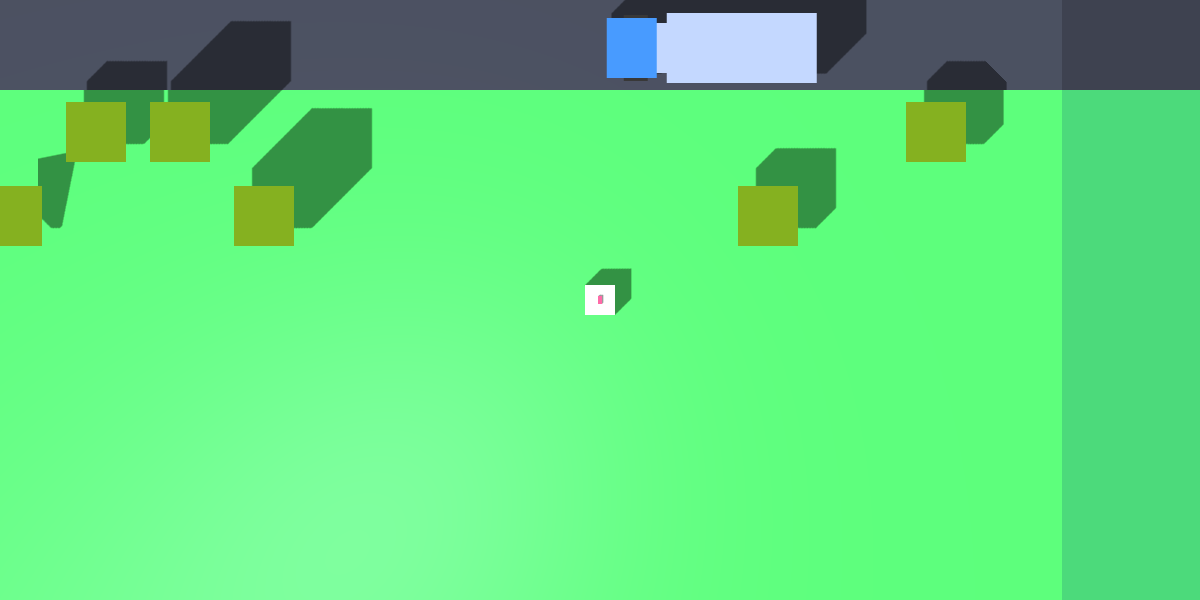

TIMESTEP 2457 / STATE train / EPSILON 0.0009999999999970072 / ACTION 3 / REWARD 0 / SCORE 0 / Q_MAX  21.924393 / Loss  6.254620552062988 / Is Dead False


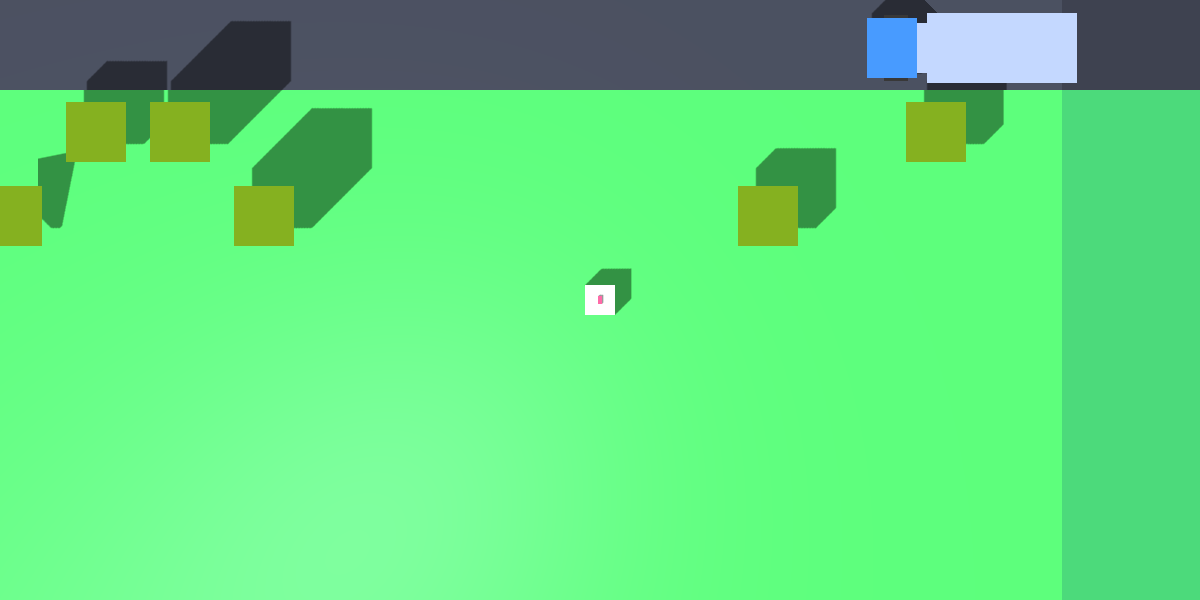

TIMESTEP 2458 / STATE train / EPSILON 0.0009999999999970072 / ACTION 3 / REWARD 0 / SCORE 0 / Q_MAX  15.498946 / Loss  17.32122802734375 / Is Dead False


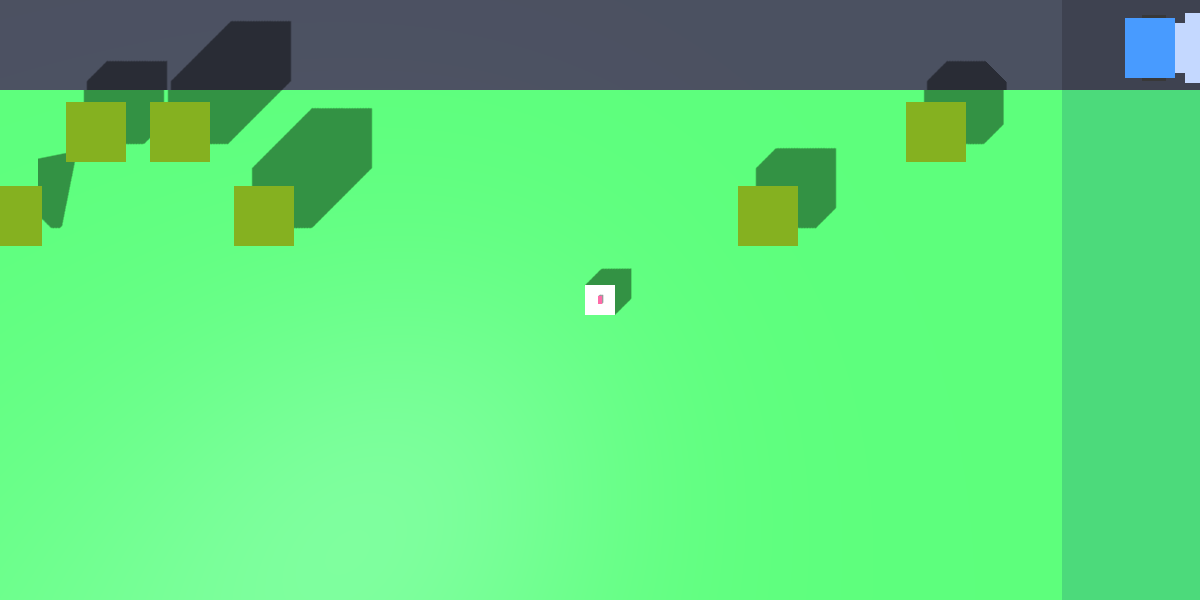

TIMESTEP 2459 / STATE train / EPSILON 0.0009999999999970072 / ACTION 3 / REWARD 0 / SCORE 0 / Q_MAX  24.576534 / Loss  14.51034164428711 / Is Dead False


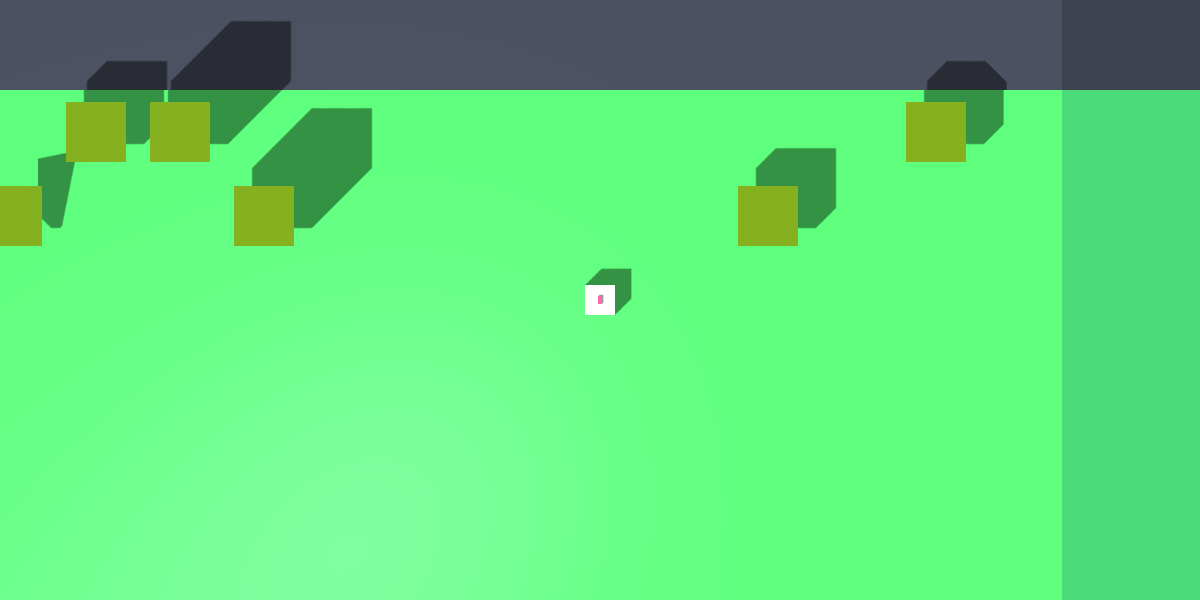

TIMESTEP 2460 / STATE train / EPSILON 0.0009999999999970072 / ACTION 0 / REWARD 0 / SCORE 0 / Q_MAX  26.547516 / Loss  7.3201446533203125 / Is Dead False


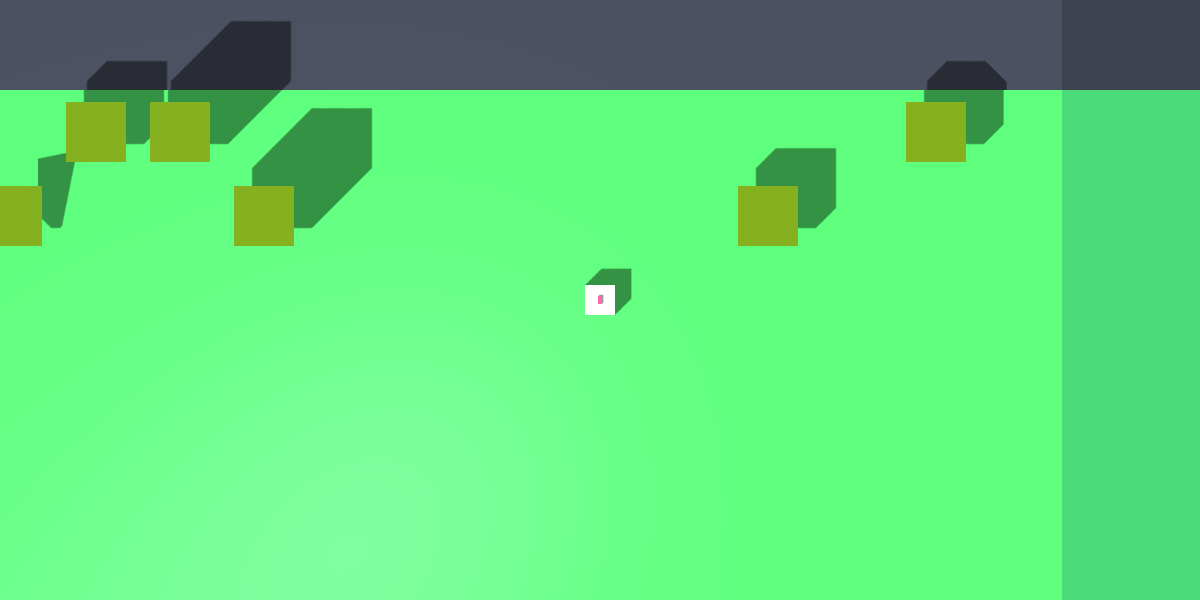

TIMESTEP 2461 / STATE train / EPSILON 0.0009999999999970072 / ACTION 2 / REWARD 0 / SCORE 0 / Q_MAX  23.818565 / Loss  4.1376495361328125 / Is Dead False


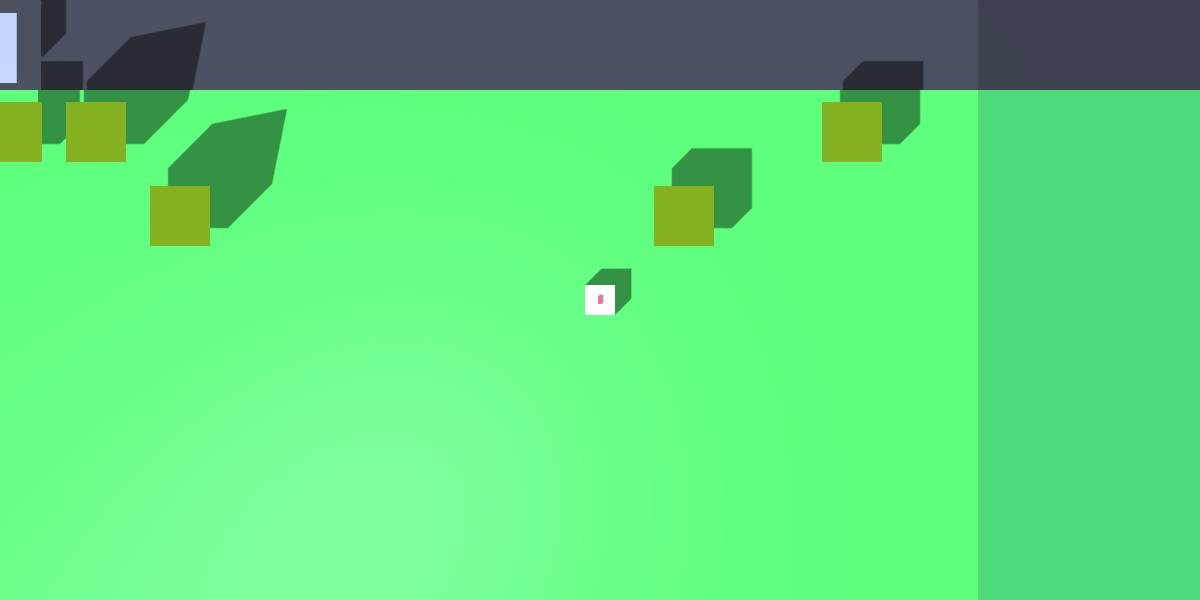

TIMESTEP 2462 / STATE train / EPSILON 0.0009999999999970072 / ACTION 1 / REWARD -10 / SCORE 0 / Q_MAX  32.95658 / Loss  6.7669525146484375 / Is Dead True


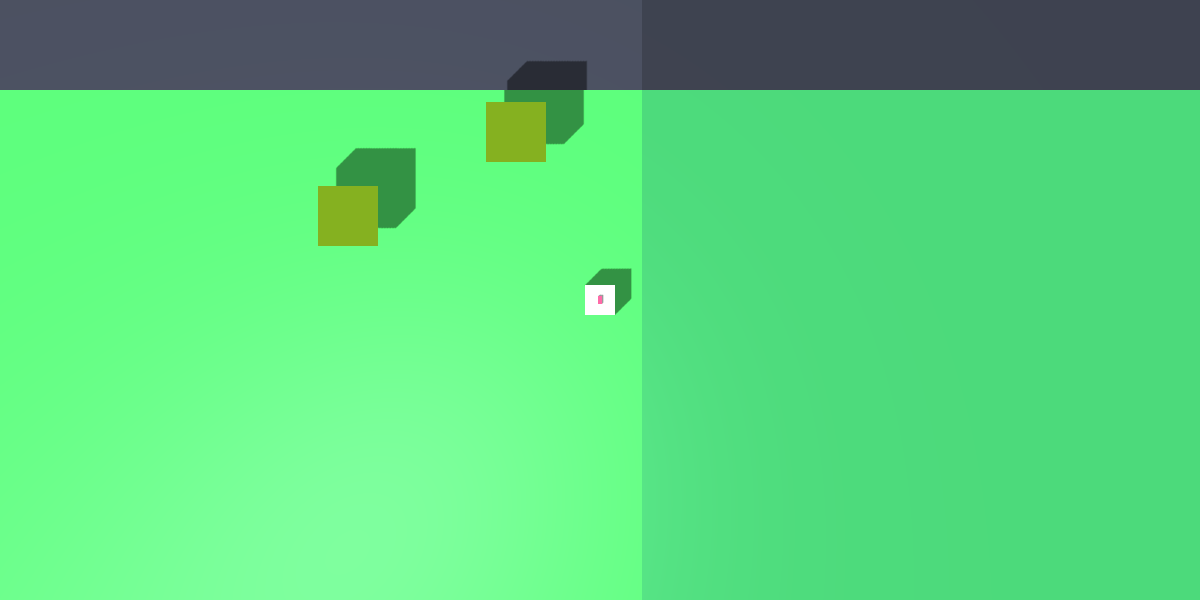

TIMESTEP 2463 / STATE train / EPSILON 0.0009999999999970072 / ACTION 3 / REWARD 0 / SCORE 0 / Q_MAX  15.823664 / Loss  3.8810737133026123 / Is Dead False


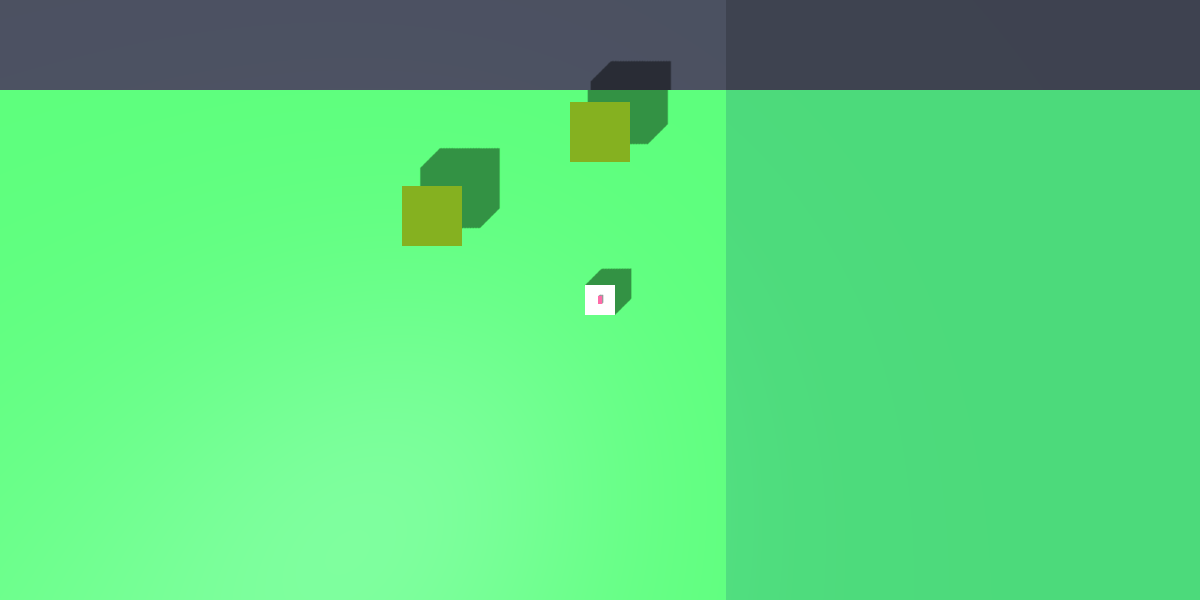

TIMESTEP 2464 / STATE train / EPSILON 0.0009999999999970072 / ACTION 0 / REWARD -10 / SCORE 0 / Q_MAX  19.726301 / Loss  3.0562384128570557 / Is Dead True


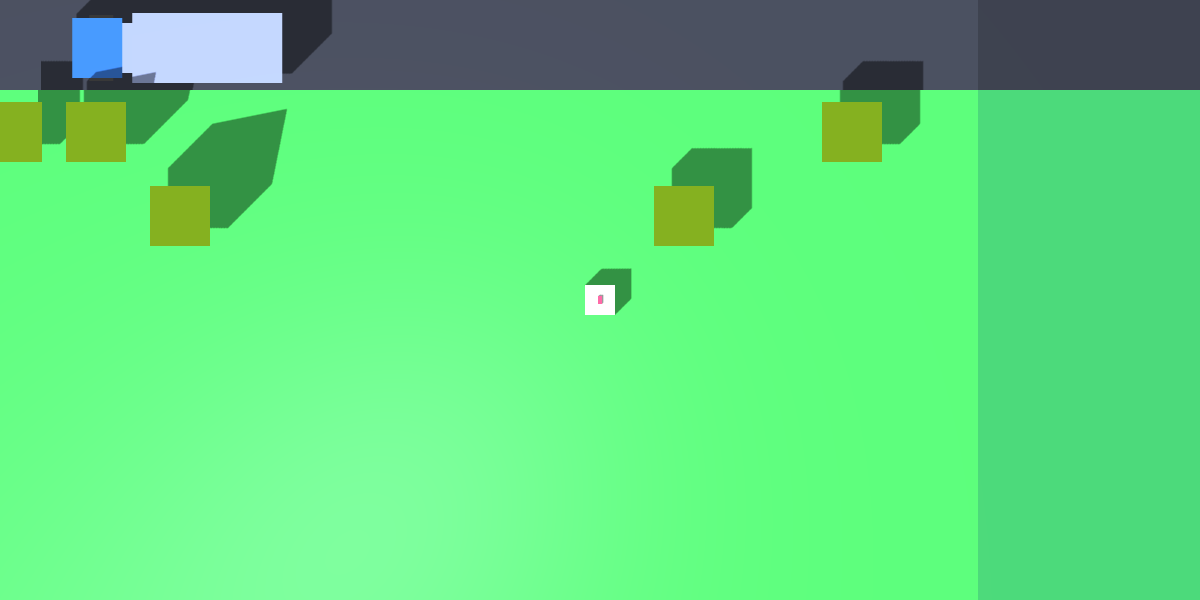

TIMESTEP 2465 / STATE train / EPSILON 0.0009999999999970072 / ACTION 3 / REWARD 0 / SCORE 0 / Q_MAX  17.652384 / Loss  4.4954833984375 / Is Dead False


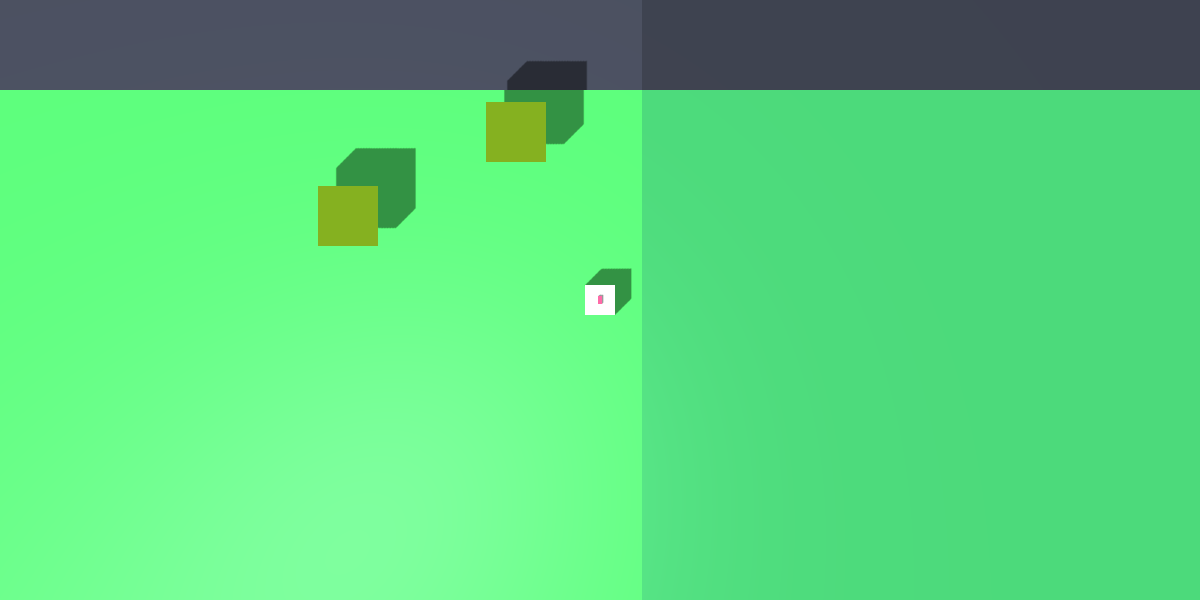

TIMESTEP 2466 / STATE train / EPSILON 0.0009999999999970072 / ACTION 1 / REWARD 0 / SCORE 0 / Q_MAX  15.256746 / Loss  2.125305652618408 / Is Dead False


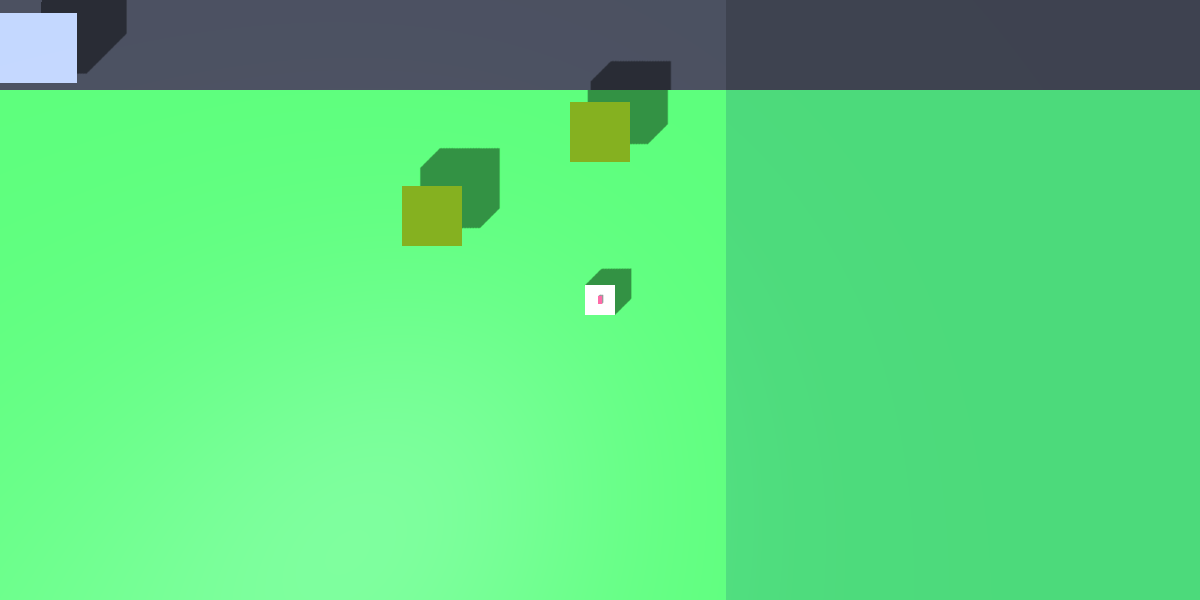

TIMESTEP 2467 / STATE train / EPSILON 0.0009999999999970072 / ACTION 1 / REWARD 0 / SCORE 0 / Q_MAX  17.171923 / Loss  5.877414703369141 / Is Dead False


In [ ]:
train_nn(model, game_state)